In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%cd ..

C:\Users\Minjae\Desktop\EEG_Project


In [2]:
import os
from cycler import cycler
import pprint
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.optim as optim

from models import *
from optim import get_lr_scheduler
from optim import lr_scheduler_list

In [3]:
output_folder = r'local/output/imgs'

In [4]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 1.11.0+cu113
cuda is available.


In [5]:
colors = ['limegreen', 'mediumpurple', 'darkorange', 
          'dodgerblue', 'lightcoral', 'goldenrod', 
          'indigo', 'darkgreen', 'navy', 'brown']

cc = (cycler(linestyle=['-', '--', '-.']) * cycler(color=colors))

print(cc)

(cycler('linestyle', ['-', '--', '-.']) * cycler('color', ['limegreen', 'mediumpurple', 'darkorange', 'dodgerblue', 'lightcoral', 'goldenrod', 'indigo', 'darkgreen', 'navy', 'brown']))


In [6]:
cfg_model = {}
cfg_model['in_channels'] = 20  # 19-21
cfg_model['out_dims'] = 3  # 2 or 3
cfg_model['seq_length'] = 2000
cfg_model['model'] = '1D-ResNeXt-5x'
cfg_model['generator'] = ResNet1D
cfg_model['block'] = 'bottleneck'
cfg_model['conv_layers'] = [3, 4, 6, 3]
cfg_model['fc_stages'] = 3
cfg_model['use_age'] = 'fc'
cfg_model['final_pool'] = 'max'
cfg_model['base_channels'] = 64
cfg_model['groups'] = 32
cfg_model['LR'] = None
cfg_model['activation'] = 'relu'
model = cfg_model['generator'](**cfg_model).to(device, dtype=torch.float32)

In [7]:
base_lr = 1
iterations = 10000  # (200000 * 32) // 64
warmup_steps = round(iterations * 0.05)  # min(max(round(iterations * 0.05), 3000), 5000)

In [15]:
# lr_scheduler_list.pop(5)
pprint.pprint(lr_scheduler_list)

['constant_with_decay',
 'constant_with_twice_decay',
 'transformer_style',
 'cosine_decay_with_warmup_half',
 'cosine_decay_with_warmup_one_and_half',
 'linear_decay_with_warmup']


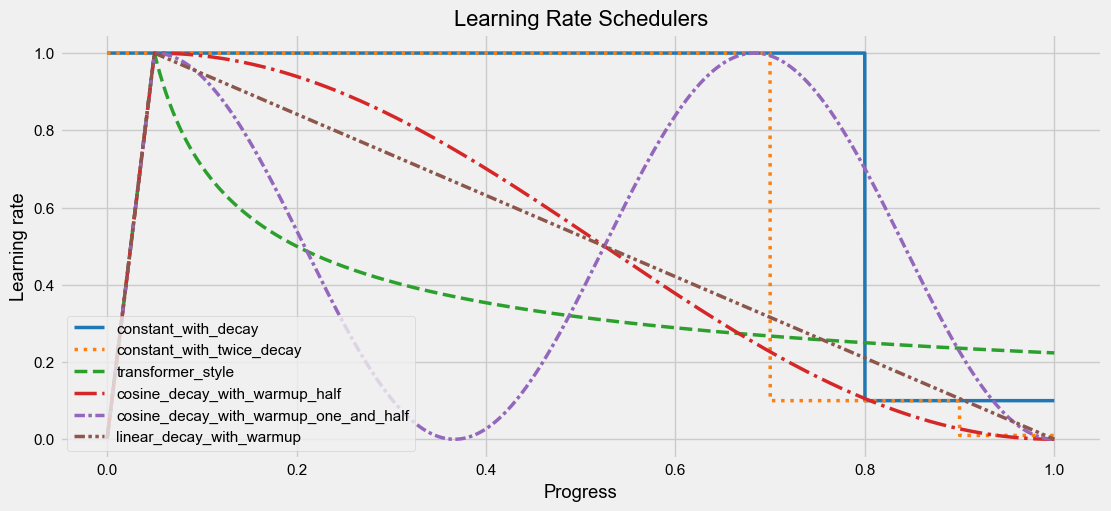

In [34]:
plt.style.use('default') 
plt.style.use('fivethirtyeight') # default, ggplot, fivethirtyeight, bmh, dark_background, classic
plt.rcParams.update({'font.size': 11})
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams["savefig.dpi"] = 1200


fig = plt.figure(num=1, clear=True, 
                 constrained_layout=True, figsize=(11.0, 5.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Learning Rate Schedulers')
ax.set_prop_cycle(cc)
ax.set_xlabel('Progress')
ax.set_ylabel('Learning rate')

from cycler import cycler
color_cycle = cycler(color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
                            'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
line_cycle = cycler(linestyle=['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 1, 1, 1)), (0, (3, 1, 1, 1, 1, 1)), 
                               (0, (5, 10)), (0, (5, 5)), (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5))])

for scheduler_type, c, s in zip(lr_scheduler_list, color_cycle(), line_cycle()):
    optimizer = optim.AdamW(model.parameters(),
                        lr=base_lr,
                        weight_decay=1e-3)
    
    
    scheduler = get_lr_scheduler(optimizer, scheduler_type=scheduler_type,
                                 iterations=iterations, warmup_steps=warmup_steps)

    lr_record = []
    
    for i in range(iterations):
        optimizer.step()
        scheduler.step()
        lr_record.append(optimizer.state_dict()['param_groups'][0]['lr'])
    
    ax.plot(np.linspace(0, 1, len(lr_record)), lr_record, lw=2.5, 
            label=scheduler_type, **c, **s)
    
ax.legend(loc='lower left')
ax.grid(True)
fig.savefig(os.path.join(output_folder, 'lr_schedule.pdf'), transparent=True)
plt.show()
fig.clear()
plt.close(fig)